In [1]:
import os
os.chdir("../")
%env CUDA_VISIBLE_DEVICES=0
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf
from data.dataset import Dataset
import data.data_selector as ds
import utils.data_processing as dp
import utils.plot_functions as pf
import analysis.analysis_picker as ap

In [3]:
class lca_4_params():
    def __init__(self):
        self.model_type = "lca_subspace"
        self.model_name = "lca_subspace_vh"
        self.version = "0.4"
        self.save_info = "Nanalysis_train_carlini_targeted"
        self.overwrite_analysis_log = False
        
class lca_8_params():
    def __init__(self):
        self.model_type = "lca_subspace"
        self.model_name = "lca_subspace_vh"
        self.version = "0.8"
        self.save_info = "lca_subspace_vh_v{}.log".format(self.version)
        self.overwrite_analysis_log = False
             
class lca_16_params():
    def __init__(self):
        self.model_type = "lca_subspace"
        self.model_name = "lca_subspace_vh"
        self.version = "0.16"
        self.save_info = "lca_subspace_vh_v{}.log".format(self.version)
        self.overwrite_analysis_log = False
        
class lca_32_params():NN
    def __init__(self):
        self.model_type = "lca_subspace"
        self.model_name = "lca_subspace_vh"
        self.version = "0.32"
        self.save_info = "lca_subspace_vh_v{}.log".format(self.version)
        self.overwrite_analysis_log = False
        
params_list = [lca_4_params(), lca_8_params(), lca_16_params(), lca_32_params()]
for params in params_list:
    params.model_dir = (os.path.expanduser("~")+"/Work/Projects/"+params.model_name)

In [4]:
analyzer_list = [ap.get_analyzer(params.model_type) for params in params_list]
for analyzer, params in zip(analyzer_list, params_list):
    analyzer.setup(params)
    analyzer.model.setup(analyzer.model_params)
    analyzer.load_analysis(save_info=params.save_info)
    analyzer.model_name = params.model_name

In [ ]:
for i in analyzer.__dict__:
    print(i)

In [ ]:
analyzer.evals

In [ ]:
analyzer.mod

In [5]:
data = ds.get_data(analyzer.model_params)
data = analyzer.model.preprocess_dataset(data, analyzer.model_params)
data = analyzer.model.reshape_dataset(data, analyzer.model_params)

INFO:preprocessing:FT Whitened train data
INFO:preprocessing:Extracted patches from train data


In [43]:
num_imgs = 10000#data["train"].images.shape[0]
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

weight_list = []
neuron_act_list = []
group_act_list = []
group_angle_list = []

for analyzer in analyzer_list:
  with tf.Session(config=config, graph=analyzer.model.graph) as sess:
    feed_dict = analyzer.model.get_feed_dict(data["train"].images[0:num_imgs,...])
    sess.run(analyzer.model.init_op, feed_dict)
    analyzer.model.load_full_model(sess, analyzer.analysis_params.cp_loc)
    
    run_list = [analyzer.model.module.w, analyzer.model.a, analyzer.model.module.group_activity, analyzer.model.module.group_angles]
    weights, neuron_activations, group_activations, group_angles = sess.run(run_list, feed_dict)
    weights_reshaped = weights.T.reshape(analyzer.model_params.num_neurons, analyzer.model_params.patch_edge_size, analyzer.model_params.patch_edge_size)
    
    weight_list.append(weights_reshaped)
    neuron_act_list.append(neuron_activations)
    group_act_list.append(group_activations)
    group_angle_list.append(group_angles)
    

INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v0.4-1000000
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v0.8-600000
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v0.16-1000000
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v0.32-1000000


In [17]:
pf.plot_group_weights(weights[0], analyzer.model_params)

AttributeError: 'LcaSubspaceModel' object has no attribute 'group_ids'

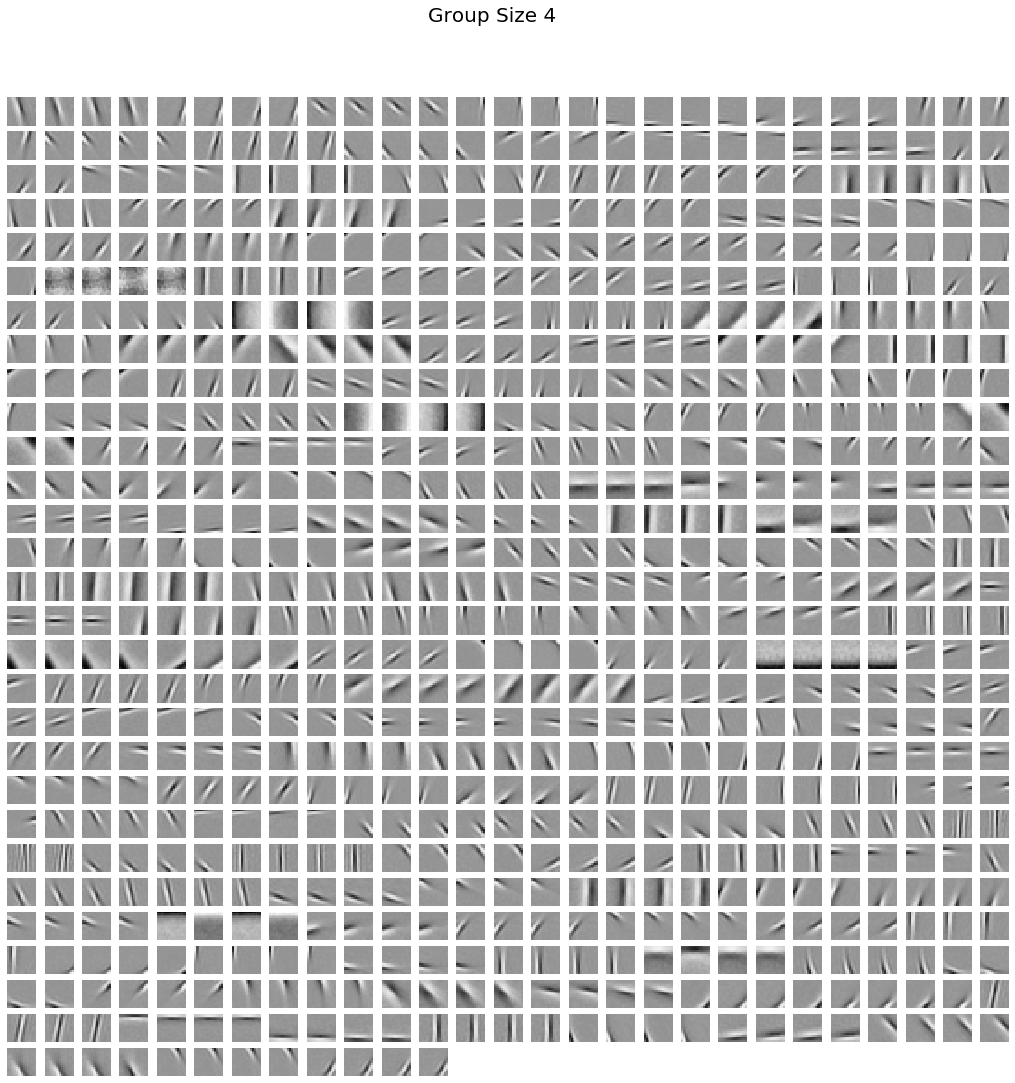

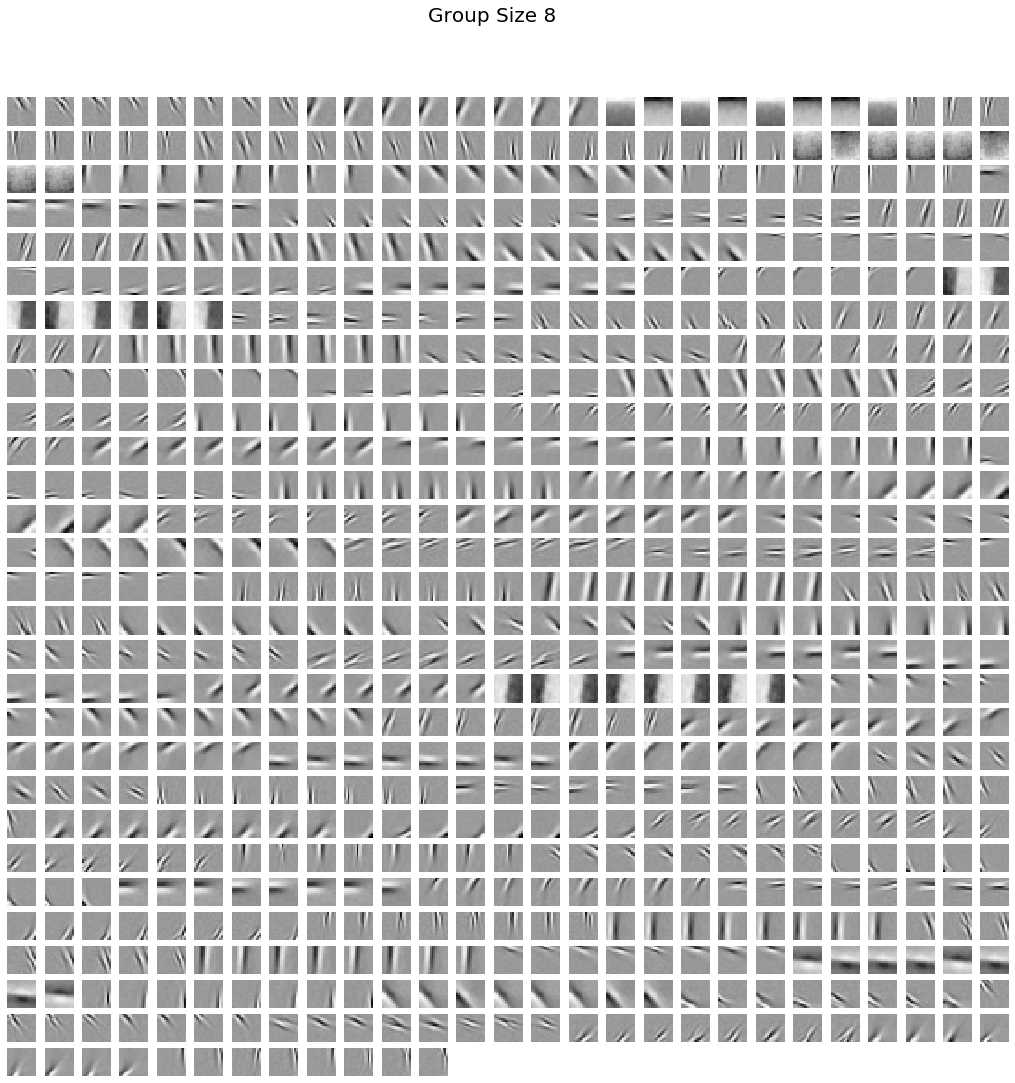

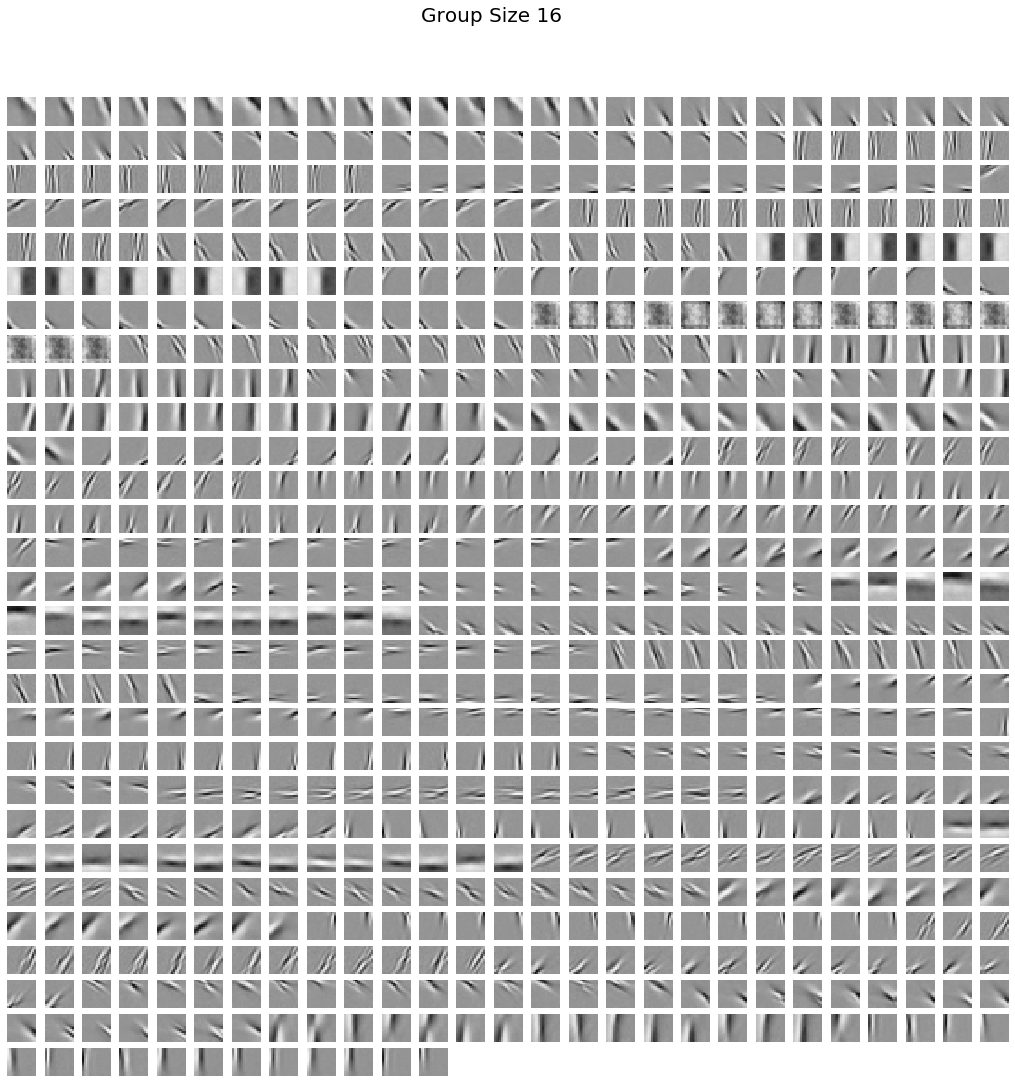

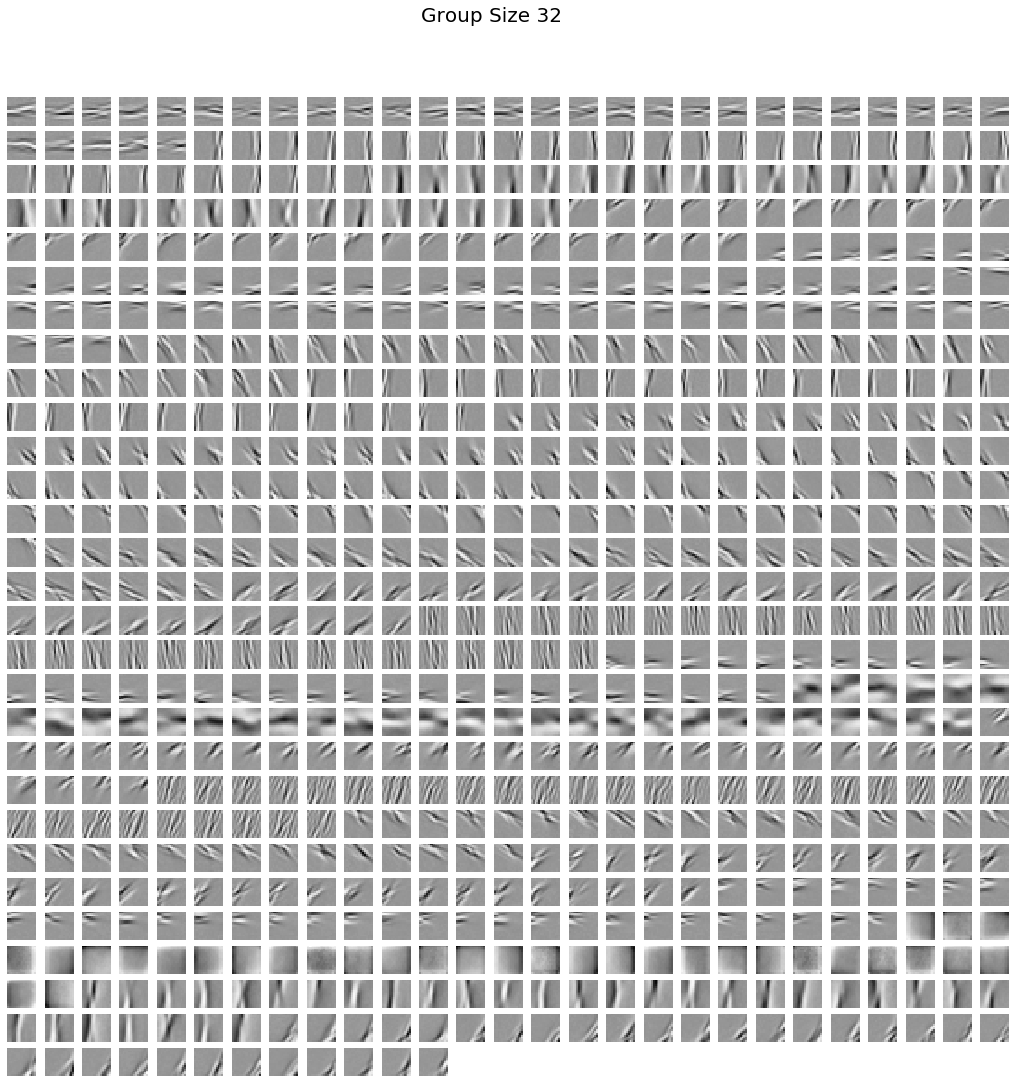

In [44]:
group_size = 4
for w in weight_list:
    plot = pf.plot_weights(w, 
                           title="Group Size {}".format(group_size), 
                           figsize=(18, 18))
    group_size = group_size*2